In [ ]:
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
import matplotlib.pyplot as plt

In [ ]:
data=[[1, 2], [3, 4]]

In [ ]:
x_data = torch.tensor(data)
x_data

In [ ]:
x_data.size()

In [ ]:
w = torch.tensor([2.0], requires_grad=True)
b = torch.tensor([1.0], requires_grad=True)

#input
x = torch.tensor([3.0])

In [ ]:
# Forward pass
y_pred = w * x + b
print(f"y_pred : {y_pred.item()}")

In [ ]:
#Loss
y_true = torch.tensor([10.0])
loss = (y_pred - y_true)**2
print(f"loss : {loss.item()}")

In [ ]:
print(f"w grad before backward: {w.grad}")

In [ ]:
loss.backward()

In [ ]:
print(f"w grad after backward: {w.grad}")

In [ ]:
learning_rate = 0.01
with torch.no_grad():
    w -= learning_rate * w.grad
    b -= learning_rate * b.grad

In [ ]:
print(f"nouveaux poids w: {w}, b: {b}")

In [ ]:
w.grad.zero_()
b.grad.zero_()
print(f"w grad after zeroing: {w.grad}")
print(f"b grad after zeroing: {b.grad}")

In [ ]:
import torch.nn as nn

perceptron = nn.Linear(1, 1)

In [ ]:
x = torch.tensor([3.0])
print(f"input x: {x}")
y_pred = perceptron(x)
print(f"prediction after weight update y_pred: {y_pred}")

In [ ]:
y_true = torch.tensor([10.0])
criterion = torch.nn.MSELoss()
loss = criterion(y_pred, y_true)

In [ ]:
loss.backward()
print(f"gradient du poids: {perceptron.weight.grad}")
print(f"gradient du biais: {perceptron.bias.grad}")

In [ ]:
optimizer = torch.optim.SGD(perceptron.parameters(), lr=0.01)
x_train = torch.tensor([[1.0], [2.0], [3.0], [4.0]])
y_train = torch.tensor([[3.0], [5.0], [7.0], [9.0]])

# for epoch in range(20):
#     for x, y in zip(x_train, y_train):
#         y_pred = perceptron(x)
#         loss = criterion(y_pred, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcl = nn.Linear(2, 4)
        self.fcl2 = nn.Linear(4, 3)
        self.fcl3 = nn.Linear(3, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fcl(x)
        x = self.relu(x)
        x = self.fcl2(x)
        x = self.relu(x)
        x = self.fcl3(x)
        x = self.sigmoid(x)
        return x

In [ ]:
model = SimpleNet()
print(model)

In [ ]:
x = torch.tensor([1.0, 2.0])
y = torch.tensor([5.0])
y_pred = model(x)
print(f"y_pred: {y_pred}")

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [ ]:

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=64, pin_memory=True, num_workers=4)

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(training_data.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

In [ ]:
print(training_data.classes)
print(training_data.data.size)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.fc(x)
        return logits

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(model)

In [ ]:
x = torch.randn(1, 28, 28, device=device)
logits = model(x)
print(logits)

In [ ]:
pred_probab = nn.Softmax(dim=1)(logits)
print(pred_probab)

In [ ]:
y_pred = pred_probab.argmax(1)
print(y_pred)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for id, value in enumerate(dataloader):
        X, y = value
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if id % 100 == 0:
            loss, current = loss.item(), (id + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("done")

In [ ]:
example_inputs = (torch.randn(1, 1, 28, 28),)
model.to("cpu")
onnx_program = torch.onnx.export(model, example_inputs, dynamo=True)
onnx_program.save("image_classifier_model.onnx")

In [ ]:
class ModelWithSoftmax(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.model = original_model
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        logits = self.model(x)
        return self.softmax(logits)

model_with_softmax = ModelWithSoftmax(model)
model_with_softmax.eval()

dummy_input = torch.randn(1, 1, 28, 28)
torch.onnx.export(
    model_with_softmax,
    dummy_input,
    "model_with_softmax.onnx",
    input_names=['input'],
    output_names=['probabilities']
)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torchmetrics

In [11]:
train_dataset = datasets.MNIST(root="data/", download=True, train=True, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root="data/", download=True, train=False, transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

writer = SummaryWriter('runs/mnist_experiment_1')

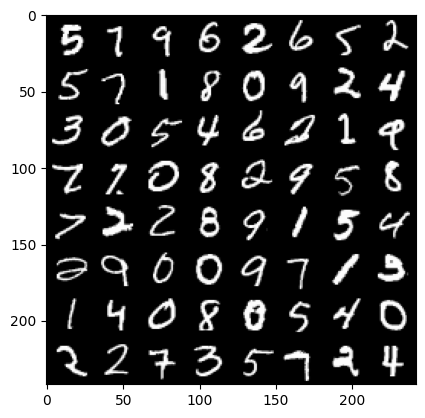

In [12]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
labels
imshow(torchvision.utils.make_grid(images))


In [13]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):

        """
        Building blocks of convolutional neural network.
        Parameters:
            * in_channels: Number of channels in the input image (for grayscale images, 1)
            * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(16 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        x = F.relu(x)              # Apply ReLU activation
        x = self.dropout(x)        # Apply dropout
        x = self.fc2(x)            # Apply second fully connected layer
        x = F.relu(x)              # Apply ReLU activation
        x = self.dropout(x)        # Apply dropout
        x = self.fc3(x)            # Apply output layer
        return x

In [14]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

model = CNN(in_channels=1, num_classes=10).to(device)
print(model)


CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [15]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [16]:
# Get one batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Log the model graph
writer.add_graph(model, images)

In [17]:
num_epochs=10
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_index % 100 == 99:
            print(f"  Step [{batch_index + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}")
            writer.add_scalar('training loss', running_loss / 100, epoch * len(train_loader) + batch_index)
            running_loss = 0.0
writer.close()


Epoch [1/10]


 12%|█▏        | 108/938 [00:01<00:12, 69.13it/s]

  Step [100/938], Loss: 1.2112


 22%|██▏       | 209/938 [00:03<00:10, 69.31it/s]

  Step [200/938], Loss: 0.4258


 33%|███▎      | 305/938 [00:04<00:09, 69.16it/s]

  Step [300/938], Loss: 0.3206


 44%|████▎     | 409/938 [00:06<00:07, 70.94it/s]

  Step [400/938], Loss: 0.2140


 55%|█████▍    | 512/938 [00:07<00:06, 70.19it/s]

  Step [500/938], Loss: 0.1795


 65%|██████▌   | 611/938 [00:09<00:04, 65.61it/s]

  Step [600/938], Loss: 0.1507


 75%|███████▌  | 706/938 [00:10<00:03, 61.18it/s]

  Step [700/938], Loss: 0.1298


 86%|████████▌ | 804/938 [00:12<00:02, 61.68it/s]

  Step [800/938], Loss: 0.1351


 96%|█████████▋| 905/938 [00:13<00:00, 68.05it/s]

  Step [900/938], Loss: 0.1240


100%|██████████| 938/938 [00:14<00:00, 65.73it/s]


Epoch [2/10]


 12%|█▏        | 111/938 [00:01<00:11, 69.10it/s]

  Step [100/938], Loss: 0.0922


 22%|██▏       | 206/938 [00:02<00:10, 68.02it/s]

  Step [200/938], Loss: 0.1022


 33%|███▎      | 310/938 [00:04<00:09, 69.50it/s]

  Step [300/938], Loss: 0.0926


 43%|████▎     | 408/938 [00:05<00:07, 68.66it/s]

  Step [400/938], Loss: 0.0861


 54%|█████▍    | 509/938 [00:07<00:06, 68.01it/s]

  Step [500/938], Loss: 0.0784


 65%|██████▍   | 609/938 [00:08<00:04, 68.42it/s]

  Step [600/938], Loss: 0.0807


 75%|███████▌  | 707/938 [00:10<00:03, 63.96it/s]

  Step [700/938], Loss: 0.0881


 86%|████████▌ | 807/938 [00:11<00:01, 67.94it/s]

  Step [800/938], Loss: 0.0774


 97%|█████████▋| 908/938 [00:13<00:00, 63.12it/s]

  Step [900/938], Loss: 0.0726


100%|██████████| 938/938 [00:13<00:00, 67.30it/s]


Epoch [3/10]


 12%|█▏        | 109/938 [00:01<00:12, 68.22it/s]

  Step [100/938], Loss: 0.0659


 22%|██▏       | 207/938 [00:03<00:10, 69.43it/s]

  Step [200/938], Loss: 0.0597


 33%|███▎      | 306/938 [00:04<00:10, 63.15it/s]

  Step [300/938], Loss: 0.0619


 44%|████▍     | 411/938 [00:06<00:08, 62.84it/s]

  Step [400/938], Loss: 0.0658


 54%|█████▍    | 510/938 [00:07<00:06, 68.41it/s]

  Step [500/938], Loss: 0.0823


 65%|██████▌   | 611/938 [00:09<00:04, 68.51it/s]

  Step [600/938], Loss: 0.0561


 76%|███████▌  | 712/938 [00:10<00:03, 69.95it/s]

  Step [700/938], Loss: 0.0612


 86%|████████▌ | 806/938 [00:11<00:01, 68.08it/s]

  Step [800/938], Loss: 0.0578


 97%|█████████▋| 912/938 [00:13<00:00, 70.07it/s]

  Step [900/938], Loss: 0.0587


100%|██████████| 938/938 [00:13<00:00, 67.62it/s]


Epoch [4/10]


 12%|█▏        | 109/938 [00:01<00:11, 70.09it/s]

  Step [100/938], Loss: 0.0525


 23%|██▎       | 214/938 [00:03<00:10, 69.69it/s]

  Step [200/938], Loss: 0.0519


 33%|███▎      | 306/938 [00:04<00:09, 65.30it/s]

  Step [300/938], Loss: 0.0470


 43%|████▎     | 406/938 [00:05<00:07, 68.78it/s]

  Step [400/938], Loss: 0.0533


 54%|█████▍    | 508/938 [00:07<00:06, 67.37it/s]

  Step [500/938], Loss: 0.0480


 65%|██████▌   | 610/938 [00:08<00:04, 68.18it/s]

  Step [600/938], Loss: 0.0492


 75%|███████▌  | 705/938 [00:10<00:03, 67.65it/s]

  Step [700/938], Loss: 0.0504


 86%|████████▌ | 807/938 [00:11<00:01, 68.17it/s]

  Step [800/938], Loss: 0.0471


 97%|█████████▋| 909/938 [00:13<00:00, 69.14it/s]

  Step [900/938], Loss: 0.0473


100%|██████████| 938/938 [00:13<00:00, 67.90it/s]


Epoch [5/10]


 12%|█▏        | 108/938 [00:01<00:11, 69.53it/s]

  Step [100/938], Loss: 0.0406


 22%|██▏       | 208/938 [00:03<00:10, 67.57it/s]

  Step [200/938], Loss: 0.0317


 33%|███▎      | 305/938 [00:04<00:09, 69.65it/s]

  Step [300/938], Loss: 0.0313


 43%|████▎     | 405/938 [00:05<00:07, 67.66it/s]

  Step [400/938], Loss: 0.0418


 55%|█████▍    | 513/938 [00:07<00:06, 67.67it/s]

  Step [500/938], Loss: 0.0407


 64%|██████▍   | 605/938 [00:08<00:05, 66.01it/s]

  Step [600/938], Loss: 0.0409


 75%|███████▌  | 708/938 [00:10<00:03, 68.69it/s]

  Step [700/938], Loss: 0.0441


 86%|████████▌ | 805/938 [00:11<00:01, 69.66it/s]

  Step [800/938], Loss: 0.0420


 97%|█████████▋| 910/938 [00:13<00:00, 67.62it/s]

  Step [900/938], Loss: 0.0417


100%|██████████| 938/938 [00:13<00:00, 68.12it/s]


Epoch [6/10]


 12%|█▏        | 110/938 [00:01<00:11, 69.84it/s]

  Step [100/938], Loss: 0.0316


 22%|██▏       | 208/938 [00:03<00:10, 70.14it/s]

  Step [200/938], Loss: 0.0330


 33%|███▎      | 311/938 [00:04<00:09, 69.06it/s]

  Step [300/938], Loss: 0.0294


 43%|████▎     | 406/938 [00:05<00:07, 67.87it/s]

  Step [400/938], Loss: 0.0416


 54%|█████▍    | 511/938 [00:07<00:06, 69.81it/s]

  Step [500/938], Loss: 0.0306


 65%|██████▍   | 607/938 [00:08<00:04, 69.18it/s]

  Step [600/938], Loss: 0.0346


 75%|███████▌  | 708/938 [00:10<00:03, 67.72it/s]

  Step [700/938], Loss: 0.0342


 86%|████████▌ | 808/938 [00:11<00:01, 67.80it/s]

  Step [800/938], Loss: 0.0359


 97%|█████████▋| 911/938 [00:13<00:00, 67.34it/s]

  Step [900/938], Loss: 0.0372


100%|██████████| 938/938 [00:13<00:00, 67.86it/s]


Epoch [7/10]


 12%|█▏        | 109/938 [00:01<00:12, 65.75it/s]

  Step [100/938], Loss: 0.0291


 22%|██▏       | 204/938 [00:03<00:10, 70.26it/s]

  Step [200/938], Loss: 0.0238


 33%|███▎      | 310/938 [00:04<00:09, 68.13it/s]

  Step [300/938], Loss: 0.0275


 44%|████▍     | 411/938 [00:06<00:07, 68.73it/s]

  Step [400/938], Loss: 0.0321


 54%|█████▍    | 508/938 [00:07<00:06, 69.05it/s]

  Step [500/938], Loss: 0.0324


 65%|██████▍   | 609/938 [00:08<00:04, 68.93it/s]

  Step [600/938], Loss: 0.0326


 76%|███████▌  | 709/938 [00:10<00:03, 67.89it/s]

  Step [700/938], Loss: 0.0296


 86%|████████▌ | 807/938 [00:12<00:02, 63.63it/s]

  Step [800/938], Loss: 0.0319


 97%|█████████▋| 908/938 [00:13<00:00, 68.62it/s]

  Step [900/938], Loss: 0.0451


100%|██████████| 938/938 [00:13<00:00, 67.11it/s]


Epoch [8/10]


 11%|█▏        | 107/938 [00:01<00:11, 69.50it/s]

  Step [100/938], Loss: 0.0292


 22%|██▏       | 210/938 [00:03<00:10, 66.99it/s]

  Step [200/938], Loss: 0.0262


 33%|███▎      | 308/938 [00:04<00:09, 69.26it/s]

  Step [300/938], Loss: 0.0289


 43%|████▎     | 408/938 [00:05<00:07, 67.58it/s]

  Step [400/938], Loss: 0.0310


 54%|█████▍    | 508/938 [00:07<00:06, 68.86it/s]

  Step [500/938], Loss: 0.0229


 65%|██████▍   | 608/938 [00:08<00:04, 67.85it/s]

  Step [600/938], Loss: 0.0182


 75%|███████▌  | 708/938 [00:10<00:03, 69.47it/s]

  Step [700/938], Loss: 0.0271


 86%|████████▌ | 807/938 [00:11<00:01, 68.61it/s]

  Step [800/938], Loss: 0.0259


 97%|█████████▋| 909/938 [00:13<00:00, 67.93it/s]

  Step [900/938], Loss: 0.0250


100%|██████████| 938/938 [00:13<00:00, 67.73it/s]


Epoch [9/10]


 11%|█         | 105/938 [00:01<00:11, 70.27it/s]

  Step [100/938], Loss: 0.0201


 23%|██▎       | 212/938 [00:03<00:10, 66.68it/s]

  Step [200/938], Loss: 0.0204


 33%|███▎      | 311/938 [00:04<00:09, 66.80it/s]

  Step [300/938], Loss: 0.0307


 44%|████▍     | 411/938 [00:06<00:07, 67.31it/s]

  Step [400/938], Loss: 0.0233


 54%|█████▍    | 506/938 [00:07<00:06, 68.69it/s]

  Step [500/938], Loss: 0.0239


 65%|██████▍   | 607/938 [00:09<00:04, 67.12it/s]

  Step [600/938], Loss: 0.0283


 75%|███████▌  | 707/938 [00:10<00:03, 67.45it/s]

  Step [700/938], Loss: 0.0311


 86%|████████▌ | 808/938 [00:12<00:01, 68.41it/s]

  Step [800/938], Loss: 0.0271


 97%|█████████▋| 910/938 [00:13<00:00, 69.05it/s]

  Step [900/938], Loss: 0.0244


100%|██████████| 938/938 [00:14<00:00, 66.93it/s]


Epoch [10/10]


 12%|█▏        | 112/938 [00:01<00:12, 67.61it/s]

  Step [100/938], Loss: 0.0176


 23%|██▎       | 212/938 [00:03<00:10, 68.35it/s]

  Step [200/938], Loss: 0.0204


 33%|███▎      | 312/938 [00:04<00:09, 68.77it/s]

  Step [300/938], Loss: 0.0166


 43%|████▎     | 408/938 [00:06<00:07, 69.84it/s]

  Step [400/938], Loss: 0.0209


 54%|█████▍    | 510/938 [00:07<00:06, 69.06it/s]

  Step [500/938], Loss: 0.0218


 65%|██████▌   | 612/938 [00:09<00:04, 69.16it/s]

  Step [600/938], Loss: 0.0179


 75%|███████▌  | 708/938 [00:10<00:03, 70.13it/s]

  Step [700/938], Loss: 0.0181


 86%|████████▌ | 806/938 [00:11<00:01, 68.69it/s]

  Step [800/938], Loss: 0.0246


 97%|█████████▋| 908/938 [00:13<00:00, 68.69it/s]

  Step [900/938], Loss: 0.0198


100%|██████████| 938/938 [00:13<00:00, 67.98it/s]


In [18]:
acc = torchmetrics.Accuracy(task="multiclass",num_classes=10)

# Iterate over the dataset batches
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        acc(preds, labels)

test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")


Test accuracy: 0.9901999831199646


In [40]:
example_inputs = (torch.randn(1, 1, 28, 28),)
model.to("cpu")
onnx_program = torch.onnx.export(model, example_inputs, dynamo=True)
onnx_program.save("CNNmodel.onnx")

[torch.onnx] Obtain model graph for `CNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `CNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
